# 3章 傾向スコアを用いた分析

In [1]:
import warnings
warnings.filterwarnings('ignore')
import sys
sys.path.append('../scripts/')

import numpy as np
import pandas as pd

import rdata
from rdd import rdd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from causalimpact import CausalImpact
from statsmodels.stats.weightstats import ttest_ind
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt

from propensity_score_matching import PropensityScoreMatching

In [2]:
# バイアスのあるデータの準備
email_data = pd.read_csv('http://www.minethatdata.com/Kevin_Hillstrom_MineThatData_E-MailAnalytics_DataMiningChallenge_2008.03.20.csv')
male_df = email_data[email_data['segment'] != 'Womens E-Mail']
male_df['treatment'] = male_df['segment'].map(lambda x: 1 if x == 'Mens E-Mail' else 0)

treatment_data = male_df[male_df['treatment'] == 1]
control_data = male_df[male_df['treatment'] == 0]

treatment_biased = treatment_data.drop(treatment_data[~(
    (treatment_data['history'] > 300) |
    (treatment_data['recency'] < 6) |
    (treatment_data['recency'] == 'Multichannel')
)].sample(frac=0.5, random_state=1).index)

control_biased = control_data.drop(control_data[
    (control_data['history'] > 300) |
    (control_data['recency'] < 6) |
    (control_data['recency'] == 'Multichannel')
].sample(frac=0.5, random_state=1).index)

biased_data = pd.concat([treatment_biased, control_biased])
biased_data.head(3)

,recency,history_segment,history,mens,womens,zip_code,newbie,channel,segment,visit,conversion,spend,treatment
3,9,5) $500 - $750,675.83,1,0,Rural,1,Web,Mens E-Mail,0,0,0.0,1
8,9,5) $500 - $750,675.07,1,1,Rural,1,Phone,Mens E-Mail,0,0,0.0,1
13,2,2) $100 - $200,101.64,0,1,Urban,0,Web,Mens E-Mail,1,0,0.0,1


## 3.1 傾向スコアの仕組み

### 3.1.2 傾向スコアの推定

In [3]:
ps_model = smf.glm(
    formula='treatment ~ recency + history + channel',
    data=biased_data,
    family=sm.families.Binomial()
).fit()

## 傾向スコアを利用した効果の推定

### 3.2.1 傾向スコアマッチング

In [4]:
biased_data['pscore'] = ps_model.predict()
biased_data_treatment = biased_data[biased_data['treatment'] == 1].reset_index(drop=True)
biased_data_control = biased_data[biased_data['treatment'] == 0].reset_index(drop=True)

p_score_match = PropensityScoreMatching(biased_data_treatment, biased_data_control)

In [5]:
p_score_match.match()

Matching : [1]. Propensity Score: 0.5047902838152997 Matched : [5080]. Propensity Score: 0.5047233476325691
Matching : [5001]. Propensity Score: 0.6080043654214355 Matched : [1251]. Propensity Score: 0.6081107023887034
Matched Ratio: 0.7850972556854909


In [6]:
matched_treatment = biased_data_treatment.iloc[list(p_score_match.create_matched_df('spend')['idx'].values)]
matched_control = biased_data_control.iloc[list(p_score_match.create_matched_df('spend')['matched_idx'].values)]
matched_data = pd.concat([matched_treatment, matched_control])
matched_data.head()

,recency,history_segment,history,mens,womens,zip_code,newbie,channel,segment,visit,conversion,spend,treatment,pscore
0,9,5) $500 - $750,675.83,1,0,Rural,1,Web,Mens E-Mail,0,0,0.0,1,0.507156
1,9,5) $500 - $750,675.07,1,1,Rural,1,Phone,Mens E-Mail,0,0,0.0,1,0.504790
2,2,2) $100 - $200,101.64,0,1,Urban,0,Web,Mens E-Mail,1,0,0.0,1,0.628079
3,5,1) $0 - $100,29.99,1,0,Surburban,0,Phone,Mens E-Mail,0,0,0.0,1,0.518280
4,9,2) $100 - $200,112.35,1,0,Rural,0,Web,Mens E-Mail,0,0,0.0,1,0.406466


In [7]:
PSM_result = smf.ols(
    'spend ~ treatment',
    data=matched_data
).fit()

PSM_result.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.6906,0.122,5.652,0.000,0.451,0.930
treatment,0.5530,0.173,3.200,0.001,0.214,0.892


### 3.2.2 逆確率重み付き推定

In [8]:
biased_data.head(3)

,recency,history_segment,history,mens,womens,zip_code,newbie,channel,segment,visit,conversion,spend,treatment,pscore
3,9,5) $500 - $750,675.83,1,0,Rural,1,Web,Mens E-Mail,0,0,0.0,1,0.507156
8,9,5) $500 - $750,675.07,1,1,Rural,1,Phone,Mens E-Mail,0,0,0.0,1,0.504790
13,2,2) $100 - $200,101.64,0,1,Urban,0,Web,Mens E-Mail,1,0,0.0,1,0.628079


In [9]:
biased_data['spend_weighted'] = biased_data.apply(lambda x: x['spend']/x['pscore'] if x['treatment'] == 1 else x['spend']/(1-x['pscore']), axis=1)
biased_data.head(3)

,recency,history_segment,history,mens,womens,zip_code,newbie,channel,segment,visit,conversion,spend,treatment,pscore,spend_weighted
3,9,5) $500 - $750,675.83,1,0,Rural,1,Web,Mens E-Mail,0,0,0.0,1,0.507156,0.0
8,9,5) $500 - $750,675.07,1,1,Rural,1,Phone,Mens E-Mail,0,0,0.0,1,0.504790,0.0
13,2,2) $100 - $200,101.64,0,1,Urban,0,Web,Mens E-Mail,1,0,0.0,1,0.628079,0.0


In [10]:
effect = (
    sum(biased_data['treatment']*biased_data['spend']/biased_data['pscore'])/sum(biased_data['treatment']/biased_data['pscore']) -
    sum((1-biased_data['treatment'])*biased_data['spend']/(1-biased_data['pscore']))/sum((1-biased_data['treatment'])/(1-biased_data['pscore']))
)

effect

0.7604499018898909

### 3.2.3 より良い傾向スコアとは

In [11]:
matched_data = pd.get_dummies(matched_data, columns=['channel'])
biased_data = pd.get_dummies(biased_data, columns=['channel'])

In [12]:
matched_data.columns

Index(['recency', 'history_segment', 'history', 'mens', 'womens', 'zip_code',
       'newbie', 'segment', 'visit', 'conversion', 'spend', 'treatment',
       'pscore', 'channel_Multichannel', 'channel_Phone', 'channel_Web'],
      dtype='object')

In [13]:
columns = ['recency', 'history', 'channel_Multichannel', 'channel_Phone', 'channel_Web']

def ASAM(df, col):
    std = df[col].std()
    mean_control = df[df['treatment'] == 0][col].mean()
    mean_treatment = df[df['treatment'] == 1][col].mean()
    return np.abs(mean_treatment-mean_control)/std

In [14]:
ASAMs_matched = {'col': [], 'ASAM': []}
for col in columns:
    ASAMs_matched['col'].append(col)
    ASAMs_matched['ASAM'].append(ASAM(matched_data, col))
    
ASAMs_matched = pd.DataFrame(ASAMs_matched)

In [15]:
ASAMs_before = {'col': [], 'ASAM': []}
for col in columns:
    ASAMs_before['col'].append(col)
    ASAMs_before['ASAM'].append(ASAM(biased_data, col))
    
ASAMs_before = pd.DataFrame(ASAMs_before)

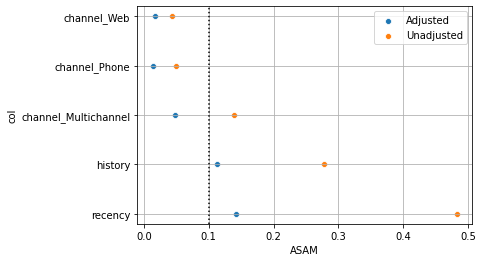

In [16]:
sns.scatterplot(data=ASAMs_matched, y='col', x='ASAM', label='Adjusted')
sns.scatterplot(data=ASAMs_before, y='col', x='ASAM', label='Unadjusted')
plt.legend()
plt.grid()

plt.axvline([0.1], ls=':', color='black')

## 3.3 機械学習を利用したメールマーケティング施策の効果推定

### 3.3.1 データの作成

In [17]:
male_df_train, male_df_test = train_test_split(male_df, test_size=0.5, random_state=1)
male_df_train = male_df_train[male_df_train.treatment == 0]

In [18]:
predicted_model = smf.glm(
    formula='conversion ~ recency + history_segment + channel + zip_code',
    data=male_df_train,
    family=sm.families.Binomial()
).fit()

In [19]:
male_df_test['pred_cv'] = predicted_model.predict(male_df_test)
male_df_test['pred_cv_rank'] = male_df_test['pred_cv'].rank(pct=True)
male_df_test['mail_assign'] = male_df_test['pred_cv_rank'].map(lambda x: np.random.binomial(n=1, p=x))

In [20]:
ml_male_df = male_df_test[
    ((male_df_test['mail_assign'] == 1) & (male_df_test['treatment'] == 1)) |
    ((male_df_test['mail_assign'] == 0) & (male_df_test['treatment'] == 0))
]
ml_male_df.head(3)

,recency,history_segment,history,mens,womens,zip_code,newbie,channel,segment,visit,conversion,spend,treatment,pred_cv,pred_cv_rank,mail_assign
40041,2,2) $100 - $200,115.63,1,0,Surburban,1,Web,No E-Mail,0,0,0.0,0,0.004892,0.551720,0
47591,10,1) $0 - $100,29.99,1,0,Urban,0,Web,No E-Mail,0,0,0.0,0,0.002842,0.300371,0
14222,10,5) $500 - $750,684.70,1,1,Urban,1,Web,No E-Mail,0,0,0.0,0,0.002331,0.204581,0


### 3.3.2 RCTと平均の比較

In [21]:
rct_male_lm = smf.ols(
    formula='spend ~ treatment',
    data=male_df_test
).fit()

rct_male_lm.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.6129,0.139,4.421,0.000,0.341,0.885
treatment,0.7364,0.195,3.772,0.000,0.354,1.119


In [22]:
ml_male_lm = smf.ols(
    formula='spend ~ treatment',
    data=ml_male_df
).fit()

ml_male_lm.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.4441,0.216,2.055,0.040,0.020,0.868
treatment,1.2385,0.304,4.075,0.000,0.643,1.834


### 3.3.3 傾向スコアを用いた分析

In [23]:
ml_male_df_treatment = ml_male_df[ml_male_df['treatment'] == 1].reset_index(drop=True)
ml_male_df_control = ml_male_df[ml_male_df['treatment'] == 0].reset_index(drop=True)

p_score_match = PropensityScoreMatching(ml_male_df_treatment, ml_male_df_control, pscore_col='pred_cv_rank')
p_score_match.match()

Matching : [1]. Propensity Score: 0.9631576477214061 Matched : [3563]. Propensity Score: 0.9664664194865538
Matched Ratio: 0.5791627906976744


In [24]:
matched_treatment = ml_male_df_treatment.iloc[list(p_score_match.create_matched_df('spend')['idx'].values)]
matched_control = ml_male_df_control.iloc[list(p_score_match.create_matched_df('spend')['matched_idx'].values)]
matched_data = pd.concat([matched_treatment, matched_control])
matched_data.head()

,recency,history_segment,history,mens,womens,zip_code,newbie,channel,segment,visit,conversion,spend,treatment,pred_cv,pred_cv_rank,mail_assign
0,4,2) $100 - $200,159.24,1,0,Urban,0,Web,Mens E-Mail,0,0,0.0,1,0.004753,0.532196,1
1,1,4) $350 - $500,495.72,1,0,Urban,0,Phone,Mens E-Mail,0,0,0.0,1,0.016967,0.963158,1
2,1,3) $200 - $350,309.78,1,0,Urban,0,Phone,Mens E-Mail,0,0,0.0,1,0.019737,0.986155,1
3,8,1) $0 - $100,29.99,1,0,Surburban,0,Web,Mens E-Mail,1,0,0.0,1,0.002926,0.314427,1
4,9,1) $0 - $100,29.99,1,0,Rural,0,Web,Mens E-Mail,1,0,0.0,1,0.003005,0.326653,1


In [25]:
PSM_result = smf.ols(
    'spend ~ treatment',
    data=matched_data
).fit()

PSM_result.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.4671,0.285,1.637,0.102,-0.092,1.027
treatment,1.1112,0.404,2.754,0.006,0.320,1.902


In [26]:
ml_male_df['spend_weighted'] = ml_male_df.apply(lambda x: x['spend']/x['pred_cv_rank'] if x['treatment'] == 1 else x['spend']/(1-x['pred_cv_rank']), axis=1)
ml_male_df.head(3)

,recency,history_segment,history,mens,womens,zip_code,newbie,channel,segment,visit,conversion,spend,treatment,pred_cv,pred_cv_rank,mail_assign,spend_weighted
40041,2,2) $100 - $200,115.63,1,0,Surburban,1,Web,No E-Mail,0,0,0.0,0,0.004892,0.551720,0,0.0
47591,10,1) $0 - $100,29.99,1,0,Urban,0,Web,No E-Mail,0,0,0.0,0,0.002842,0.300371,0,0.0
14222,10,5) $500 - $750,684.70,1,1,Urban,1,Web,No E-Mail,0,0,0.0,0,0.002331,0.204581,0,0.0


In [27]:
effect = (
    sum(ml_male_df['treatment']*ml_male_df['spend']/ml_male_df['pred_cv_rank'])/sum(ml_male_df['treatment']/ml_male_df['pred_cv_rank']) -
    sum((1-ml_male_df['treatment'])*ml_male_df['spend']/(1-ml_male_df['pred_cv_rank']))/sum((1-ml_male_df['treatment'])/(1-ml_male_df['pred_cv_rank']))
)

effect

1.4718128482887307

## 3.4 LaLondeデータセットの分析

### 3.4.1 導入

In [28]:
cps1_data = pd.read_stata('https://users.nber.org/~rdehejia/data/cps_controls.dta')
cps3_data = pd.read_stata('https://users.nber.org/~rdehejia/data/cps_controls3.dta')
nswdw_data = pd.read_stata('https://users.nber.org/~rdehejia/data/nsw_dw.dta')

HTTPError: HTTP Error 403: Forbidden

In [ ]:
cps1_data.head(3)

In [ ]:
cps3_data.head(3)

In [ ]:
nswdw_data.head(3)

In [ ]:
# NSWデータから介入グループだけ取り出してCPS1と付ける
cps1_nsw_data = nswdw_data.loc[nswdw_data['treat'] == 1]
cps1_nsw_data = pd.concat([cps1_nsw_data, cps1_data])

# NSWデータから介入グループだけ取り出してCPS3と付ける
cps3_nsw_data = nswdw_data.loc[nswdw_data['treat'] == 1]
cps3_nsw_data = pd.concat([cps3_nsw_data, cps3_data])

### 3.4.2 RCTによる結果の確認

In [ ]:
nsw_cov = smf.ols(
    data=nswdw_data,
    formula='re78 ~ treat + re74 + re75 + age + education + black + hispanic + nodegree + married'
).fit()

nsw_cov.summary().tables[1]

### 3.4.3 回帰分析による効果の推定

In [ ]:
# CPS1の分析結果
cps1_reg = smf.ols(
    data=cps1_nsw_data,
    formula='re78 ~ treat + re74 + re75 + age + education + black + hispanic + nodegree + married'
).fit()

cps1_reg.summary().tables[1]

In [ ]:
# CPS3の分析結果
cps3_reg = smf.ols(
    data=cps3_nsw_data,
    formula='re78 ~ treat + re74 + re75 + age + education + black + hispanic + nodegree + married'
).fit()

cps3_reg.summary().tables[1]

### 3.4.4 傾向スコアによる効果の推定

In [ ]:
cps1_nsw_data['re74_2'] = cps1_nsw_data['re74']**2
cps1_nsw_data['re75_2'] = cps1_nsw_data['re75']**2


model = smf.glm(
    formula='treat ~ age + education + black + hispanic + nodegree + married + re74 + re75 + re74_2 + re75_2',
    data=cps1_nsw_data,
    family=sm.families.Binomial()
).fit()

In [ ]:
cps1_nsw_data['pscore'] = model.predict(cps1_nsw_data)

In [ ]:
cps1_nsw_data_treatment = cps1_nsw_data[cps1_nsw_data['treat'] == 1].reset_index(drop=True)
cps1_nsw_data_control = cps1_nsw_data[cps1_nsw_data['treat'] == 0].reset_index(drop=True)

p_score_match = PropensityScoreMatching(cps1_nsw_data_treatment, cps1_nsw_data_control)

In [ ]:
p_score_match.match()

In [ ]:
matched_treatment = cps1_nsw_data_treatment.iloc[list(p_score_match.create_matched_df('re78')['idx'].values)]
matched_control = cps1_nsw_data_control.iloc[list(p_score_match.create_matched_df('re78')['matched_idx'].values)]
matched_data = pd.concat([matched_treatment, matched_control])
matched_data.head(3)

In [ ]:
PSM_result_cps1 = smf.ols(
    data=matched_data,
    formula='re78 ~ treat'
).fit()

PSM_result_cps1.summary().tables[1]

In [ ]:
def ASAM(df, col):
    std = df[col].std()
    mean_control = df[df['treat'] == 0][col].mean()
    mean_treatment = df[df['treat'] == 1][col].mean()
    return np.abs(mean_treatment-mean_control)/std

In [ ]:
columns = ['age', 'education', 'black', 'hispanic', 'nodegree', 'married', 're74', 're75', 're74_2', 're75_2']

In [ ]:
ASAMs_matched = {'col': [], 'ASAM': []}
for col in columns:
    ASAMs_matched['col'].append(col)
    ASAMs_matched['ASAM'].append(ASAM(matched_data, col))
    
ASAMs_matched = pd.DataFrame(ASAMs_matched)

In [ ]:
ASAMs_before = {'col': [], 'ASAM': []}
for col in columns:
    ASAMs_before['col'].append(col)
    ASAMs_before['ASAM'].append(ASAM(cps1_nsw_data, col))
    
ASAMs_before = pd.DataFrame(ASAMs_before)

In [ ]:
# 共変量のバランスを確認
sns.scatterplot(data=ASAMs_matched, y='col', x='ASAM', label='Adjusted')
sns.scatterplot(data=ASAMs_before, y='col', x='ASAM', label='Unadjusted')
plt.legend()
plt.grid()

plt.axvline([0.1], ls=':', color='black')

In [ ]:
# 重み付きのre78を算出
cps1_nsw_data['re78_weighted'] = cps1_nsw_data.apply(lambda x: x['re78']/x['pscore'] if x['treat'] == 1 else x['re78']/(1-x['pscore']), axis=1)
cps1_nsw_data.head(3)

In [ ]:
# 重み付きデータでの効果の推定
IPW_result = (
    sum(cps1_nsw_data['treat']*cps1_nsw_data['re78']/cps1_nsw_data['pscore'])/sum(cps1_nsw_data['treat']/cps1_nsw_data['pscore']) -
    sum((1-cps1_nsw_data['treat'])*cps1_nsw_data['re78']/(1-cps1_nsw_data['pscore']))/sum((1-cps1_nsw_data['treat'])/(1-cps1_nsw_data['pscore']))
)

IPW_result